<a href="https://colab.research.google.com/github/YangWorking/Deep_learning/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import recall_score, precision_score, roc_curve, roc_auc_score, auc
import time

In [ ]:
# Hyperparameters

##############################
batch_size = 32
# batch_size = 64
# batch_size = 128
##############################
# Learning rate
initial_lr = 0.001
# initial_lr = 0.005
# initial_lr = 0.01
##############################
# weight_decay = 0.00001
# weight_decay = 0.0005
# weight_decay = 0.00075
weight_decay = 0.001
# weight_decay = 0
##############################
# drop_out = 0
# drop_out = 0.1
# drop_out = 0.2
# drop_out = 0.3
# drop_out = 0.4
drop_out = 0.5
##############################
# Early stopping
# epochs_max = 100
epochs_max = 200
patience_valid_loss = 6
patience_lr = 3

In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop images with padding
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Training dataset and loader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Validation dataset and loader
validset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

# Testing dataset and loader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Classic LeNet architecture
class Basic_Net(nn.Module):
    def __init__(self):
        super(Basic_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(3, 6, 5)
        nn.init.xavier_uniform_(self.conv1.weight)  # Xavier initialization
        self.bn1 = nn.BatchNorm2d(6)  # Batch Normalization

        # Max-Pooling Layer 1
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        nn.init.xavier_uniform_(self.conv2.weight)  # Xavier initialization
        self.bn2 = nn.BatchNorm2d(16)  # Batch Normalization

        # Fully Connected Layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        nn.init.xavier_uniform_(self.fc1.weight)  # Xavier initialization
        self.bn3 = nn.BatchNorm1d(120)  # Batch Normalization

        self.fc2 = nn.Linear(120, 84)
        nn.init.xavier_uniform_(self.fc2.weight)  # Xavier initialization
        self.bn4 = nn.BatchNorm1d(84)  # Batch Normalization

        self.fc3 = nn.Linear(84, 10)

        # Dropout Layer
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.dropout(x)     # droup out layer before activation functions
        x = self.fc3(x)
        return x

In [ ]:
class DeeperNet(nn.Module):
    def __init__(self):
        super(DeeperNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        nn.init.xavier_uniform_(self.conv1.weight)    # Apply Xavier initialization
        self.bn1 = nn.BatchNorm2d(32)                 # Batch Normaliza1on

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        nn.init.xavier_uniform_(self.conv2.weight)    # Apply Xavier initialization
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        nn.init.xavier_uniform_(self.conv3.weight)    # Apply Xavier initialization
        self.bn3 = nn.BatchNorm2d(128)                # Batch Normaliza1on

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        nn.init.xavier_uniform_(self.fc1.weight)      # Apply Xavier initialization
        self.bn4 = nn.BatchNorm1d(512)                # Batch Normaliza1on

        self.fc2 = nn.Linear(512, 256)
        nn.init.xavier_uniform_(self.fc2.weight)      # Apply Xavier initialization
        self.bn5 = nn.BatchNorm1d(256)                # Batch Normaliza1on

        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
# network, device, Loss function, optimizer and lr_scheduler

# net = Net()
net = DeeperNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=initial_lr, weight_decay=0)
optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=weight_decay)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=patience_lr, factor=0.1, verbose=True)

In [ ]:
# function for training
def train_model(net, trainloader, optimizer, criterion, device):
    net.train()
    train_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Convert to NumPy arrays for scikit-learn
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    average_train_loss = train_loss / len(trainloader)
    train_accuracy = correct / total
    recall = recall_score(true_labels, predicted_labels, average='macro')
    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=1)

    return average_train_loss, train_accuracy, recall, precision

# function for validation
def valid_model(net, validloader, criterion, device):
    net.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Convert to NumPy arrays for scikit-learn
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    average_valid_loss = valid_loss / len(validloader)
    valid_accuracy = correct / total
    recall = recall_score(true_labels, predicted_labels, average='macro')
    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=1)

    return average_valid_loss, valid_accuracy, recall, precision


In [ ]:
# Main training loop
def train_loop (net, trainloader, validloader, optimizer, criterion, device, epochs_max, patience_valid_loss):
    best_valid_loss = float('inf')
    patience = patience_valid_loss
    start_time = time.time()  # Record the start time

    for epoch in range(epochs_max):
        train_loss, train_accuracy, train_recall, train_precision = train_model(net, trainloader, optimizer, criterion, device)
        valid_loss, valid_accuracy, valid_recall, valid_precision = valid_model(net, validloader, criterion, device)

        # Learning rate scheduler
        lr_scheduler.step(valid_loss)

        # Early stopping
        if valid_loss < best_valid_loss:
            patience = patience_valid_loss # reset patience
            best_valid_loss = valid_loss
        else:
            patience -= 1

        # Monitoring
        print()
        print(f"Epoch {epoch + 1}   Patience_epoch {patience}   LR {optimizer.param_groups[0]['lr']}")
        print(f"Training      Loss: {train_loss:.4} accuracy: {train_accuracy:.4} recall: {train_recall:.4} precision: {train_precision:.4}")
        print(f"Validation    Loss: {valid_loss:.4} accuracy: {valid_accuracy:.4} recall: {valid_recall:.4} precision: {valid_precision:.4}")

        # Breaking the loop if patience reduces to 0
        if patience == 0:
            print(f'Early stopping after {epoch + 1} epochs without improvement in validation loss.')
            break

        # Store metrics
        training_metrics.append({
            'epoch': epoch + 1,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'loss': train_loss,
            'accuracy': train_accuracy,
            'recall': train_recall,
            'precision': train_precision
        })

        validation_metrics.append({
            'epoch': epoch + 1,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'loss': valid_loss,
            'accuracy': valid_accuracy,
            'recall': valid_recall,
            'precision': valid_precision
        })

    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time

    print(f"Finished Training. Elapsed Time: {elapsed_time:.2f} seconds")

    return

In [ ]:
# empty lists to store metrics
training_metrics = []
validation_metrics = []

print(f"Batch: {batch_size} LR:{initial_lr} Patient_epoch:{patience_valid_loss} Patient_lr:{patience_lr} weight_decay:{weight_decay} Dropout:{drop_out}")

train_loop(net, trainloader, validloader, optimizer, criterion, device, epochs_max, patience_valid_loss)

Batch: 32 LR:0.001 Patient_epoch:6 Patient_lr:3 weight_decay:0.001 Dropout:0.5

Epoch 1   Patience_epoch 6   LR 0.001
Training      Loss: 1.657 accuracy: 0.3955 recall: 0.3955 precision: 0.3885
Validation    Loss: 1.337 accuracy: 0.5093 recall: 0.5093 precision: 0.5165

Epoch 2   Patience_epoch 6   LR 0.001
Training      Loss: 1.354 accuracy: 0.5117 recall: 0.5117 precision: 0.5047
Validation    Loss: 1.178 accuracy: 0.5802 recall: 0.5802 precision: 0.5792

Epoch 3   Patience_epoch 6   LR 0.001
Training      Loss: 1.208 accuracy: 0.5711 recall: 0.5711 precision: 0.5658
Validation    Loss: 1.053 accuracy: 0.6315 recall: 0.6315 precision: 0.6338

Epoch 4   Patience_epoch 6   LR 0.001
Training      Loss: 1.109 accuracy: 0.6097 recall: 0.6097 precision: 0.6052
Validation    Loss: 0.965 accuracy: 0.6595 recall: 0.6595 precision: 0.6557

Epoch 5   Patience_epoch 6   LR 0.001
Training      Loss: 1.042 accuracy: 0.6299 recall: 0.6299 precision: 0.6257
Validation    Loss: 0.9071 accuracy: 0.682

In [ ]:
# Function to test the trained model on the test set
def test_model(net, testloader, device):
    net.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect true labels and predicted probabilities
            true_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    test_accuracy = correct / total

    # Calculate AUC-ROC score
    auc_roc = roc_auc_score(true_labels, predicted_probs, average='macro', multi_class='ovr')

    return test_accuracy, round(auc_roc,3)

# Call the test_model function
test_accuracy, auc_roc = test_model(net, testloader, device)
print(f"Accuracy on the test set: {test_accuracy:.3}")
print(f"AUC-ROC on the test set: {auc_roc}")

Accuracy on the test set: 0.855
AUC-ROC on the test set: 0.988


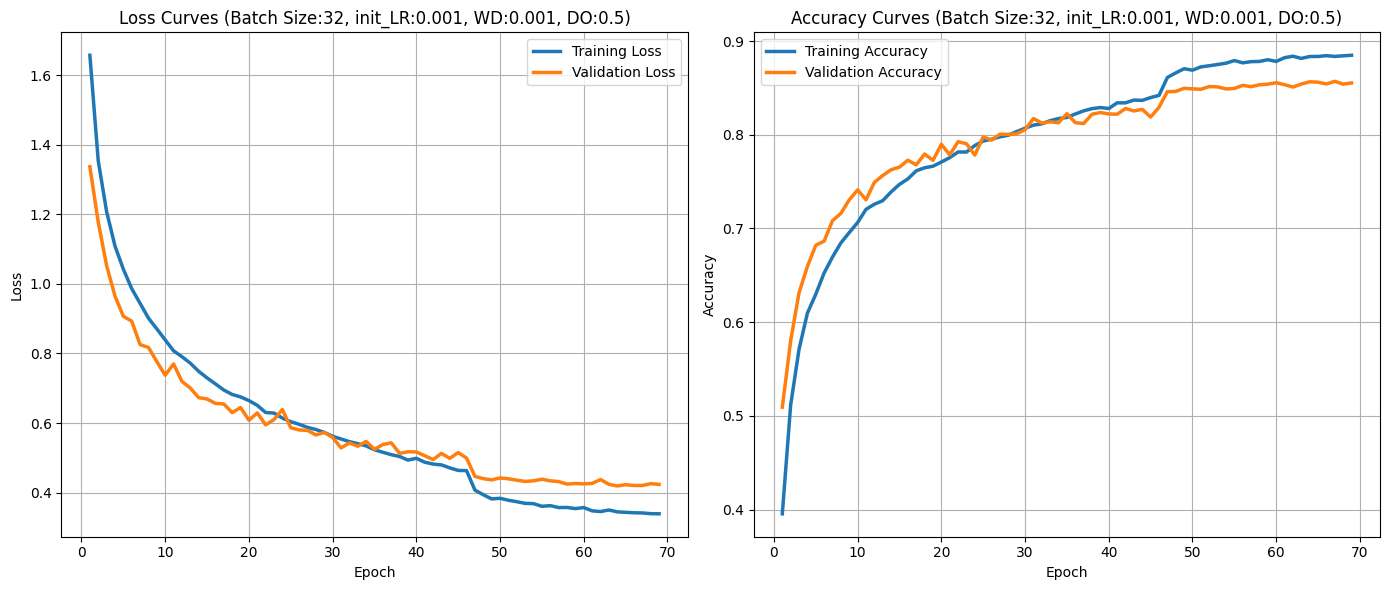

In [ ]:
def plot(training_metrics, validation_metrics, batch_size):
    # Extract the training and validation losses and accuracies from the metrics
    train_losses = [metric['loss'] for metric in training_metrics]
    valid_losses = [metric['loss'] for metric in validation_metrics]
    train_accuracies = [metric['accuracy'] for metric in training_metrics]
    valid_accuracies = [metric['accuracy'] for metric in validation_metrics]

    # Create an array of epoch numbers for the x-axis
    epochs = range(1, len(training_metrics) + 1)

    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the training and validation loss curves in the first subplot
    axs[0].plot(epochs, train_losses, label='Training Loss', linewidth=2.5)
    axs[0].plot(epochs, valid_losses, label='Validation Loss', linewidth=2.5)
    axs[0].set_title(f'Loss Curves (Batch Size:{batch_size}, init_LR:{initial_lr}, WD:{weight_decay}, DO:{drop_out})')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot the training and validation accuracy curves in the second subplot
    axs[1].plot(epochs, train_accuracies, label='Training Accuracy', linewidth=2.5)
    axs[1].plot(epochs, valid_accuracies, label='Validation Accuracy', linewidth=2.5)
    axs[1].set_title(f'Accuracy Curves (Batch Size:{batch_size}, init_LR:{initial_lr}, WD:{weight_decay}, DO:{drop_out})')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()




    axs[1].grid(True)

    # Adjust the layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

plot(training_metrics, validation_metrics, batch_size)

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 87 %
Accuracy of   car : 96 %
Accuracy of  bird : 73 %
Accuracy of   cat : 64 %
Accuracy of  deer : 84 %
Accuracy of   dog : 82 %
Accuracy of  frog : 90 %
Accuracy of horse : 93 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %
